In [20]:
from google.colab import files
# Upload the CSV
uploaded = files.upload()

Saving 1C-Penn-GPA-and-HS-Data.csv to 1C-Penn-GPA-and-HS-Data.csv


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import relu
import random
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from math import sqrt

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

# Configuration
torch.set_default_dtype(torch.float64)
plt.style.use('default')

# Load data from the CSV file, skipping the header, and convert to a PyTorch tensor
data = torch.from_numpy(np.genfromtxt('1C-Penn-GPA-and-HS-Data.csv', delimiter=",", skip_header=1, dtype = float))


# Compute the mean and standard deviation of each variable
means = torch.mean(data[:,1:4], dim = 0)
stds = torch.std(data[:,1:4], dim = 0)

# Substract the mean and divide by the std each variable
data_norm = data.clone()
data_norm[:, 1:4] = (data[:, 1:4] - means) / stds

# Select the normalized HS GPA, SAT scores
x = data_norm[:,1:3]
# The targets are the normalized Penn GPA values
y = data_norm[:,3]

print(f"Number of students: {data.shape[0]}")
print(f"Number of variables: {data.shape[1]}")

Number of students: 600
Number of variables: 6


In [22]:
class TwoLayerNN(torch.nn.Module):
    def __init__(self, p1=20):
        super().__init__()
        # First layer has input dimension 2 (SAT, GPA) and output dimension p1
        self.A1 = nn.parameter.Parameter(torch.rand(2, p1)-0.5)
        # Second layer has input dimension p1 and output dimension 1 (predicted GPA)
        self.A2 = nn.parameter.Parameter(torch.rand(p1, 1)-0.5)
    def forward(self, x0):
        # Compute output of first layer
        x1 = relu(torch.matmul(x0, self.A1))
        # Compute output of second layer
        x2 = relu(torch.matmul(x1,self.A2))
        return x2

In [23]:
# Task 2
# Randomly shuffle indices for creating training and testing splits
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Number of test samples
numTest = 100
# Number of training samples
numTrain = dataset_size - numTest
print(f"Num Train = {numTrain}, numTest = {numTest}")

train_indices, test_indices = indices[numTest:], indices[:numTest]

# Create training and testing datasets
train_dataset = TensorDataset(x[train_indices], y[train_indices])
test_dataset = TensorDataset(x[test_indices], y[test_indices])


Num Train = 500, numTest = 100


In [24]:
# Define a function to evaluate the MSE
def evaluate(dataloader, estimator):
    mse = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            yHat = estimator.forward(x_batch).squeeze()
            mse += torch.sum((yHat-y_batch)**2)
    numSamples = len(dataloader.dataset)
    mse /= numSamples
    return mse.item()

Train loss: 0.5876004933545627 
Test loss: 0.669245626655795 


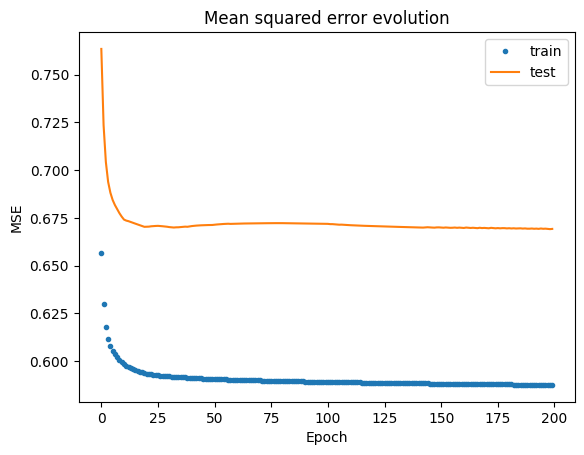

In [39]:
# Specification of learning parametrization
estimator = TwoLayerNN(40)

# Define parameters used in training loop
epsilon=0.01
batch_size = 64

# Specify the optimizer that is used to perform descent updates
optimizer = optim.SGD(estimator.parameters(), lr=epsilon, momentum=0)


# Instantiate Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Lists to record the evolution of the MSE during training and testing
mse_evolution = []
mse_evolution_test = []


# Training loop: iterates over the dataset n_epoch times
n_epochs = 200
for _ in range(n_epochs):
    # Iterate over all batches in the dataset
    for x_batch, y_batch in train_loader:

        # Set gradients to zero
        estimator.zero_grad()

        # Compute predictions
        yHat = estimator.forward(x_batch).squeeze()

        # Compute MSE
        mse = torch.mean((yHat-y_batch)**2)

        # Compute gradients
        mse.backward()

        # Update model parameters
        optimizer.step()

    # Evaluate the model on the training dataset and record the MSE
    epoch_mse = evaluate(train_loader, estimator)
    mse_evolution.append(epoch_mse)

    # Evaluate the model on the testing dataset and record the MSE
    mseTest = evaluate(test_loader, estimator)
    mse_evolution_test.append(mseTest)

# Print the final MSE on the training dataset
print(f"Train loss: {mse_evolution[-1]} ")

# Print the final MSE on the testing dataset
print(f"Test loss: {mse_evolution_test[-1]} ")

# Plot the evolution of the MSE loss over epochs for training and testing
_ = plt.plot(mse_evolution, ".", label="train")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("MSE")
_ = plt.plot(mse_evolution_test, "-", label="test")
_ = plt.legend()

The difference in the testing and training errors indicates that the model does not perfectly predicts the outcome. The similarity in the risks means that the model does not purely memorizes the training data but develops a process to generate predications based on the data.

In [35]:
class TwoLayerNN(torch.nn.Module):
    def __init__(self, p1=20):
        super().__init__()
        # First layer has input dimension 2 (SAT, GPA) and output dimension p1
        self.A1 = nn.parameter.Parameter(torch.rand(3, p1)-0.5)
        # Second layer has input dimension p1 and output dimension 1 (predicted GPA)
        self.A2 = nn.parameter.Parameter(torch.rand(p1, 1)-0.5)
    def forward(self, x0):
        # Compute output of first layer
        x1 = relu(torch.matmul(x0, self.A1))
        # Compute output of second layer
        x2 = relu(torch.matmul(x1,self.A2))
        return x2

In [49]:
# Create a gender tensor that is < 0 if it is Male and > 0 if it is Female
gender =  data_norm[:,4] -  data_norm[:,5]

# Normalize
gender = (gender - torch.mean(gender)) / torch.std(gender)

# Select the normalized HS GPA, SAT scores, and add the gender as a column
x = torch.hstack((data_norm[:,1:3], gender.unsqueeze(1)))
# The targets are the normalized Penn GPA values
y = data_norm[:,3]


# Create training and testing datasets
train_dataset = TensorDataset(x[train_indices], y[train_indices])
test_dataset = TensorDataset(x[test_indices], y[test_indices])
x_test = x[test_indices]
y_test = y[test_indices]
test_dataset_male = TensorDataset(x_test[x[test_indices, 2] < 0], y_test[x[test_indices, 2] < 0])
test_dataset_female = TensorDataset(x_test[x[test_indices, 2] > 0], y_test[x[test_indices, 2] > 0])

Train loss: 0.7765933338260693 
Test loss: 0.8100185665419221 
Male Test loss: 0.4651316008964805 
Female Test loss: 1.1038111669065576 


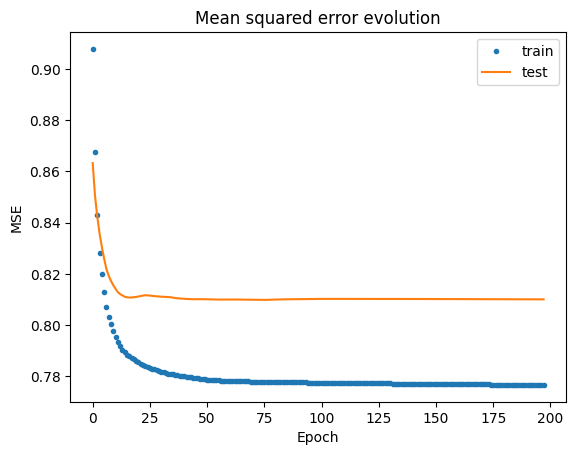

In [59]:

# Specification of learning parametrization
estimator = TwoLayerNN(40)

# Parameters used in training loop
epsilon = 0.01
batch_size = 64

# Specify the optimizer that is used to perform descent updates
optimizer = optim.SGD(estimator.parameters(), lr=epsilon, momentum=0)

# Instantiate Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loader_male = DataLoader(test_dataset_male, batch_size=batch_size)
test_loader_female = DataLoader(test_dataset_female, batch_size=batch_size)

# Lists to record the evolution of the MSE during training and testing
mse_evolution = []
mse_evolution_test = []
mse_evolution_test_male = []
mse_evolution_test_female = []

# Training loop: iterates over the dataset n_epoch times
n_epochs = 200
for _ in range(n_epochs):
    # Iterate over all batches in the dataset
    for x_batch, y_batch in train_loader:

        # Set gradients to zero
        estimator.zero_grad()

        # Compute predictions
        yHat = estimator.forward(x_batch).squeeze()

        # Compute MSE
        mse = torch.mean((yHat-y_batch)**2)

        # Compute gradients
        mse.backward()

        # Update model parameters
        optimizer.step()
    epoch_mse = evaluate(train_loader, estimator)
    mse_evolution.append(epoch_mse)

    mseTest = evaluate(test_loader, estimator)
    mse_evolution_test.append(mseTest)

# Print train results
print(f"Train loss: {mse_evolution[-1]} ")

# Print test results
print(f"Test loss: {mse_evolution_test[-1]} ")

mseTestMale = evaluate(test_loader_male, estimator)
mse_evolution_test_male.append(mseTestMale)
mseTestFemale = evaluate(test_loader_female, estimator)
mse_evolution_test_female.append(mseTestFemale)

print(f"Male Test loss: {mse_evolution_test_male[-1]} ")



print(f"Female Test loss: {mse_evolution_test_female[-1]} ")

# Plot the evolution of the MSE loss over epochs for training and testing
_ = plt.plot(mse_evolution[2:], ".", label="train")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("MSE")
_ = plt.plot(mse_evolution_test[2:], "-", label="test")
_ = plt.legend()

In [58]:
# Calculare average predicted GPA for males
male_indexes = gender < 0
male_yHat = torch.mean(estimator.forward(x[male_indexes]).squeeze())

# Calculate average predicted GPA for females
female_indexes = gender > 0
female_yHat = torch.mean(estimator.forward(x[female_indexes]).squeeze())

print(f"Average Male GPA: {stds[2] * male_yHat + means[2]} ")
print(f"Average Female GPA: {stds[2] * female_yHat + means[2]}")

Average Male GPA: 3.772876790337897 
Average Female GPA: 3.719216666666666
